# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"

In [47]:
NN_PARAMETER_SEARCH_PREFIX = "conv_lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
SAMPLE_RATIO = 0.15

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

doc_vec_types = "extended_abs_desc_claims_large_sample_chunks"
doc_vec_preprocessed_data_types = "extended_pv_abs_desc_claims_large_sample_chunks"

exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(big_data_location, "parameter_search_doc2vec_models_" + doc_vec_types, "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_" + doc_vec_types)
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
# training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
# validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
# test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

preprocessed_location = os.path.join(big_data_location, "preprocessed_data", doc_vec_preprocessed_data_types) + "/"

training_preprocessed_files_prefix = preprocessed_location + "extended_pv_training_docs_data_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "extended_pv_validation_docs_data_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "extended_pv_test_docs_data_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

# Load general data required for classification

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 15.2 s, sys: 944 ms, total: 16.1 s
Wall time: 16.1 s


In [11]:
len(training_docs_list)

254767

In [12]:
len(validation_docs_list)

60957

In [13]:
len(test_docs_list)

79785

# Utility Functions for data loading

In [14]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector
    
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [15]:
class FixedDocumentsStatsGenerator(object):
    def __init__(self, filename_prefix):
        self.filename_prefix = filename_prefix
        self.docids = []
        self.doc_parts = defaultdict(list)
        self.doc_part_chunks = defaultdict(list)
        self.curr_doc_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        info("Loading new batch for index: {}".format(self.curr_doc_index))
        true_docs_count = 0
        try:
            with open(self.filename_prefix + str(self.curr_doc_index)) as preproc_file:
                for line in preproc_file:
                    line_array = line.split(" ", 1)
                    entity_id = line_array[0].strip()
                    if self.is_doc(entity_id):
                        self.docids.append(entity_id)
                        true_docs_count+= 1
                    elif self.is_doc_part(entity_id):
                        self.doc_parts[self.get_doc_id(entity_id)].append(entity_id)
                    elif self.is_doc_part_chunk(entity_id):
                        self.doc_part_chunks[self.get_doc_id(entity_id)].append(entity_id)
            self.batch_end = self.curr_doc_index + true_docs_count - 1 
            info("Finished loading new batch of {} documents".format(true_docs_count))
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_doc_index))
            raise StopIteration()
    def get_stats(self):
        try:
            while True:
                if self.curr_doc_index > self.batch_end:
                    self.load_new_batch_in_memory()
                self.curr_doc_index = self.batch_end + 1
        except StopIteration:
            pass
            
    def get_doc_id(self, entity_id):
        return entity_id.split("_")[0]
    def get_entity_parts(self, entity_id):
        return entity_id.split("_")
    def is_doc(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 1:
            return True
        return False
    def is_doc_part(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 2:
            return True
        return False
    def is_doc_part_chunk(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 3:
            return True
        return False

In [16]:
def get_doc_vector(entity_id):
    if entity_id in doc2vec_model.docvecs:
        if DOC2VEC_MMAP:
            normal_array = []
            normal_array[:] = doc2vec_model.docvecs[entity_id][:]
            return normal_array
        else:
            return doc2vec_model.docvecs[entity_id]
    else:
        # some claims have low token count, so they cant fill out the whole 16 spots
        return ZERO_VECTOR

def data_generator(doc_stats, doc_id):
    yield get_doc_vector(doc_id)
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield get_doc_vector(part_id)
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    while True:
        yield ZERO_VECTOR

def validation_data_generator(doc_stats, validation_dict, doc_id):
    yield validation_dict[doc_id]
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield validation_dict[part_id]
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield validation_dict[part_id]
    while True:
        yield ZERO_VECTOR
        

In [17]:
def get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for training
    """
    def get_training_y_labels():
        """
        Creates or loads the y matrix used for training
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_LABELS_MATRIX.format(classifications_type))):
            info("Creating Training Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(training_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            training_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                            TRAINING_LABELS_MATRIX.format(classifications_type))))
        return training_labels_mat

    
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Training Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        training_data = np.ndarray((len(training_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Training Data shape: {}".format(training_data.shape))
        training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(training_docs_list):
            data_gen = data_generator(doc_stats, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3rd level: feature vectors
                training_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in training".format(i))
        
        info("Saving Training Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL)), "w"), training_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_LABELS_MATRIX.format(classifications_type)), "w"), training_labels_mat)
    else:
        info("Loading Training Data from file")
        training_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL))))
        training_labels_mat = get_training_y_labels()
        
    return training_data, training_labels_mat

In [18]:
def get_validation_data(validation_dict, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for validation
    """
    def get_validation_y_labels():
        """
        Creates or loads the y matrix used for validation
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_LABELS_MATRIX.format(classifications_type))):
            info("Creating Validation Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(validation_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            info("Loading Validation Labels")
            validation_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                        VALIDATION_LABELS_MATRIX.format(classifications_type))))
        return validation_labels_mat

    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Validation Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        validation_data = np.ndarray((len(validation_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Validation Data shape: {}".format(validation_data.shape))
        validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(validation_docs_list):
            data_gen = validation_data_generator(doc_stats, validation_dict, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3d level: feature vectors
                validation_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in validation".format(i))
        
        info("Saving Validation Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL)), "w"), validation_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_LABELS_MATRIX.format(classifications_type)), "w"), validation_labels_mat)
    else:
        info("Loading Validation Data from file")
        validation_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))))
        validation_labels_mat = get_validation_y_labels()
        
    return validation_data, validation_labels_mat

In [19]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [56]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

# Global Param Loop

In [21]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [22]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

In [40]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [67]:
GLOBAL_PARMS_TO_RUN = [
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 500,
#         'lstm_conv_filter_length': 8,
#         'lstm_max_pooling_length': 2
#     },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 200,
#         'lstm_conv_filter_length': 32,
#         'lstm_max_pooling_length': 2
#     },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 500,
#         'lstm_conv_filter_length': 8,
#         'lstm_max_pooling_length': 4
#     },
#         {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 200,
#         'lstm_conv_filter_length': 8,
#         'lstm_max_pooling_length': 4
#     },
#         {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 500,
#         'lstm_conv_filter_length': 32,
#         'lstm_max_pooling_length': 4
#     },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 200,
#         'lstm_conv_filter_length': 8,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 500,
#         'lstm_conv_filter_length': 8,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DIVISIONS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': 1000,
#         'lstm_conv_filter_length': 40,
#         'lstm_max_pooling_length': None
#     },
    {
        'doc2vec_epoch': 8,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': 500,
        'lstm_conv_filter_length': 40,
        'lstm_max_pooling_length': None
    },
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': 40, 'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 500}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-02 14:55:11,987 : INFO : Loading Training Document Stats
2017-04-02 14:55:29,977 : INFO : Loading Training Data from file


Max Size: 34


2017-04-02 14:56:17,164 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-04-02 14:56:21,422 : INFO : Loading Validation Data from file
2017-04-02 14:56:32,684 : INFO : Loading Validation Labels
2017-04-02 14:56:32,697 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/conv_lstm_sections_level_2_batch_2048_nn_parameter_searches.pkl
2017-04-02 14:56:32,699 : INFO : ***************************************************************************************
2017-04-02 14:56:32,700 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_500_conv-filter-length_40_max-pooling-size_None


(60957, 34, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_32 (Convolution1D) (None, 34, 500)       4000500     convolution1d_input_32[0][0]     
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     convolution1d_32[0][0]           
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 6006508
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


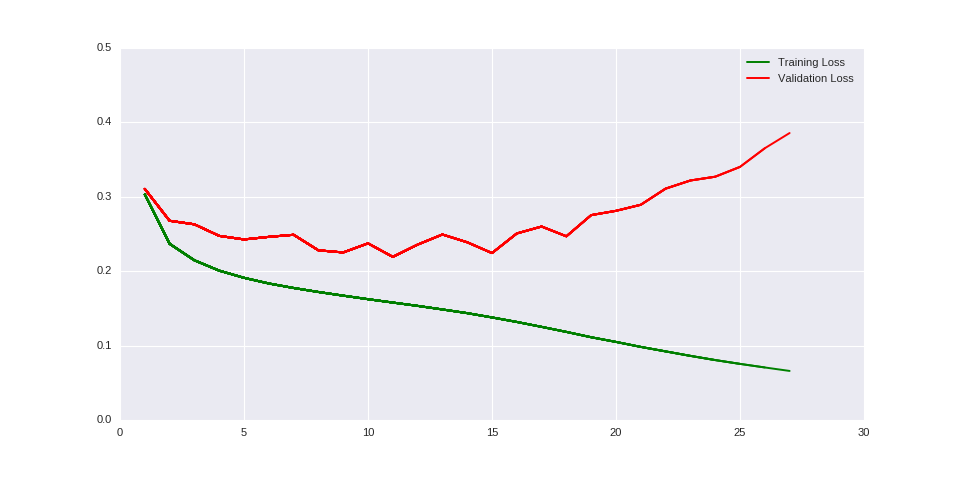

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3033

2017-04-02 14:59:05,594 : INFO : Found lower val loss for epoch 1 => 0.31061


254767/254767 [==============================] - 138s - loss: 0.3032 - val_loss: 0.3106
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2369

2017-04-02 15:01:30,351 : INFO : Found lower val loss for epoch 2 => 0.26779


254767/254767 [==============================] - 144s - loss: 0.2368 - val_loss: 0.2678
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2147

2017-04-02 15:03:53,083 : INFO : Found lower val loss for epoch 3 => 0.263


254767/254767 [==============================] - 142s - loss: 0.2147 - val_loss: 0.2630
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2008

2017-04-02 15:06:13,509 : INFO : Found lower val loss for epoch 4 => 0.24749


254767/254767 [==============================] - 140s - loss: 0.2008 - val_loss: 0.2475
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1911

2017-04-02 15:08:37,848 : INFO : Found lower val loss for epoch 5 => 0.24269


254767/254767 [==============================] - 144s - loss: 0.1911 - val_loss: 0.2427
Epoch 6/200
254767/254767 [==============================] - 159s - loss: 0.1835 - val_loss: 0.2461
Epoch 7/200
254767/254767 [==============================] - 159s - loss: 0.1774 - val_loss: 0.2490
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1721

2017-04-02 15:16:35,672 : INFO : Found lower val loss for epoch 8 => 0.22808


254767/254767 [==============================] - 159s - loss: 0.1721 - val_loss: 0.2281
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1671

2017-04-02 15:19:08,951 : INFO : Found lower val loss for epoch 9 => 0.2252


254767/254767 [==============================] - 153s - loss: 0.1671 - val_loss: 0.2252
Epoch 10/200
254767/254767 [==============================] - 146s - loss: 0.1624 - val_loss: 0.2374
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1579

2017-04-02 15:24:02,713 : INFO : Found lower val loss for epoch 11 => 0.21927


254767/254767 [==============================] - 147s - loss: 0.1579 - val_loss: 0.2193
Epoch 12/200
254767/254767 [==============================] - 148s - loss: 0.1534 - val_loss: 0.2357
Epoch 13/200
254767/254767 [==============================] - 206s - loss: 0.1486 - val_loss: 0.2493
Epoch 14/200
254767/254767 [==============================] - 294s - loss: 0.1436 - val_loss: 0.2389
Epoch 15/200
254767/254767 [==============================] - 163s - loss: 0.1379 - val_loss: 0.2244
Epoch 16/200
254767/254767 [==============================] - 155s - loss: 0.1318 - val_loss: 0.2507
Epoch 17/200
254767/254767 [==============================] - 146s - loss: 0.1252 - val_loss: 0.2601
Epoch 18/200
254767/254767 [==============================] - 146s - loss: 0.1184 - val_loss: 0.2469
Epoch 19/200
254767/254767 [==============================] - 147s - loss: 0.1112 - val_loss: 0.2754
Epoch 20/200
254767/254767 [==============================] - 146s - loss: 0.1050 - val_loss: 0.2812
Epo

2017-04-02 16:07:06,250 : INFO : Evaluating on Training Data
2017-04-02 16:10:19,936 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.298 | Top 3: 0.995 | Top 5: 0.999 | F1 Micro: 0.959 | F1 Macro: 0.920


2017-04-02 16:10:26,520 : INFO : Evaluating on Validation Data using saved best weights
2017-04-02 16:11:11,313 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.698 | Top 3: 0.940 | Top 5: 0.989 | F1 Micro: 0.673 | F1 Macro: 0.609


In [68]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    doc2vec_model = None

    training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
    validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

    print GLOBAL_VARS.MODEL_NAME
    
#     print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
#     if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
#         doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
#         doc2vec_model.workers = NUM_CORES
#         GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
#     else:
#         info("Couldnt find the doc2vec model with epoch {}".format(epoch))
#         raise Exception()
    
    time.sleep(0.2)
    
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))
    
    MAX_SIZE = 1 # for document vector
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PARTS

    if PARTS_LEVEL >= LEVEL_CHUNKS:
        MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PART_CHUNKS

    print "Max Size: {}".format(MAX_SIZE)
    
    X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)
    print X.shape
    print y.shape
    
    validation_dict = None
#     validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))
    Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)
    print Xv.shape
    print yv.shape
    
    
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))


    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
    time.sleep(0.2)
    info('Evaluating on Training Data')
    yp = model.predict(X) # get raw probability for predicted labels
    yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

    if save_results:
#         if load_existing_results:
#             if os.path.exists(param_results_path):
#                 info('Loading Previous results from {}'.format(param_results_path))
#                 loaded_param_results_dict = pickle.load(open(param_results_path))
#                 param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))
        

==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 32}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 03:30:04,165 : INFO : Loading Training Document Stats
2017-04-01 03:30:20,984 : INFO : Loading Training Data from file


Max Size: 4


2017-04-01 03:30:21,261 : INFO : Loading Validation Document Stats


(254767, 4, 200)
(254767, 8)


2017-04-01 03:30:28,447 : INFO : Loading Validation Data from file
2017-04-01 03:30:28,503 : INFO : Loading Validation Labels
2017-04-01 03:30:28,507 : INFO : ***************************************************************************************
2017-04-01 03:30:28,509 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_32


(60957, 4, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_2 (Convolution1D)  (None, 4, 32)         19232       convolution1d_input_2[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           1066000     convolution1d_2[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 1089240
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


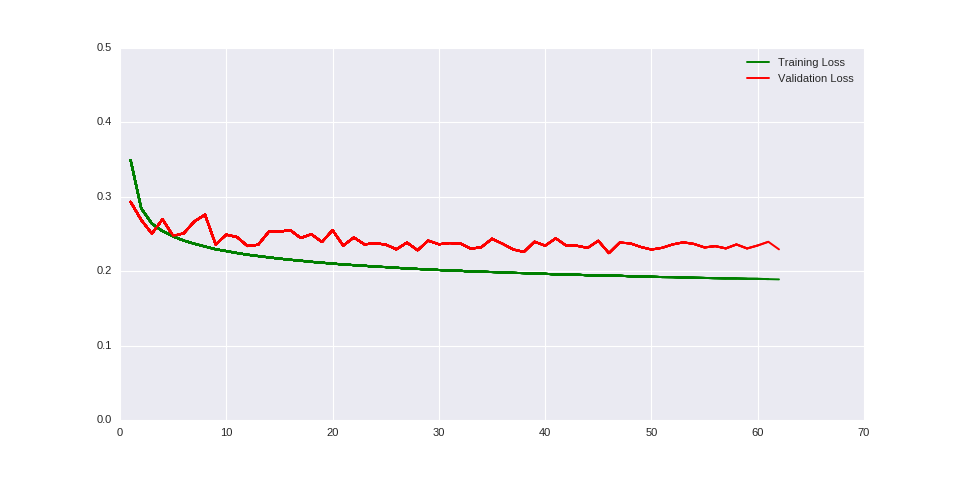

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3494

2017-04-01 03:30:50,895 : INFO : Found lower val loss for epoch 1 => 0.29321


254767/254767 [==============================] - 10s - loss: 0.3493 - val_loss: 0.2932
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2843

2017-04-01 03:31:02,058 : INFO : Found lower val loss for epoch 2 => 0.26882


254767/254767 [==============================] - 11s - loss: 0.2843 - val_loss: 0.2688
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2640

2017-04-01 03:31:12,635 : INFO : Found lower val loss for epoch 3 => 0.25051


254767/254767 [==============================] - 10s - loss: 0.2640 - val_loss: 0.2505
Epoch 4/200
254767/254767 [==============================] - 10s - loss: 0.2538 - val_loss: 0.2697
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2467

2017-04-01 03:31:34,036 : INFO : Found lower val loss for epoch 5 => 0.24738


254767/254767 [==============================] - 10s - loss: 0.2468 - val_loss: 0.2474
Epoch 6/200
254767/254767 [==============================] - 10s - loss: 0.2411 - val_loss: 0.2510
Epoch 7/200
254767/254767 [==============================] - 11s - loss: 0.2369 - val_loss: 0.2669
Epoch 8/200
254767/254767 [==============================] - 10s - loss: 0.2332 - val_loss: 0.2759
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2295

2017-04-01 03:32:18,242 : INFO : Found lower val loss for epoch 9 => 0.23587


254767/254767 [==============================] - 11s - loss: 0.2295 - val_loss: 0.2359
Epoch 10/200
254767/254767 [==============================] - 13s - loss: 0.2270 - val_loss: 0.2491
Epoch 11/200
254767/254767 [==============================] - 13s - loss: 0.2244 - val_loss: 0.2460
Epoch 12/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2221

2017-04-01 03:32:58,329 : INFO : Found lower val loss for epoch 12 => 0.2338


254767/254767 [==============================] - 13s - loss: 0.2222 - val_loss: 0.2338
Epoch 13/200
254767/254767 [==============================] - 13s - loss: 0.2204 - val_loss: 0.2356
Epoch 14/200
254767/254767 [==============================] - 13s - loss: 0.2186 - val_loss: 0.2530
Epoch 15/200
254767/254767 [==============================] - 13s - loss: 0.2169 - val_loss: 0.2530
Epoch 16/200
254767/254767 [==============================] - 11s - loss: 0.2154 - val_loss: 0.2554
Epoch 17/200
254767/254767 [==============================] - 10s - loss: 0.2141 - val_loss: 0.2446
Epoch 18/200
254767/254767 [==============================] - 10s - loss: 0.2126 - val_loss: 0.2497
Epoch 19/200
254767/254767 [==============================] - 11s - loss: 0.2114 - val_loss: 0.2393
Epoch 20/200
254767/254767 [==============================] - 12s - loss: 0.2102 - val_loss: 0.2551
Epoch 21/200
254767/254767 [==============================] - 12s - loss: 0.2091 - val_loss: 0.2344
Epoch 22/200


2017-04-01 03:35:51,482 : INFO : Found lower val loss for epoch 26 => 0.22938


254767/254767 [==============================] - 12s - loss: 0.2046 - val_loss: 0.2294
Epoch 27/200
254767/254767 [==============================] - 13s - loss: 0.2037 - val_loss: 0.2385
Epoch 28/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2030

2017-04-01 03:36:17,625 : INFO : Found lower val loss for epoch 28 => 0.22818


254767/254767 [==============================] - 13s - loss: 0.2030 - val_loss: 0.2282
Epoch 29/200
254767/254767 [==============================] - 13s - loss: 0.2025 - val_loss: 0.2411
Epoch 30/200
254767/254767 [==============================] - 13s - loss: 0.2016 - val_loss: 0.2362
Epoch 31/200
254767/254767 [==============================] - 13s - loss: 0.2010 - val_loss: 0.2378
Epoch 32/200
254767/254767 [==============================] - 13s - loss: 0.2006 - val_loss: 0.2374
Epoch 33/200
254767/254767 [==============================] - 13s - loss: 0.1995 - val_loss: 0.2302
Epoch 34/200
254767/254767 [==============================] - 13s - loss: 0.1992 - val_loss: 0.2323
Epoch 35/200
254767/254767 [==============================] - 13s - loss: 0.1989 - val_loss: 0.2436
Epoch 36/200
254767/254767 [==============================] - 13s - loss: 0.1986 - val_loss: 0.2368
Epoch 37/200
254767/254767 [==============================] - 13s - loss: 0.1977 - val_loss: 0.2292
Epoch 38/200


2017-04-01 03:38:31,403 : INFO : Found lower val loss for epoch 38 => 0.22585


254767/254767 [==============================] - 13s - loss: 0.1974 - val_loss: 0.2258
Epoch 39/200
254767/254767 [==============================] - 13s - loss: 0.1970 - val_loss: 0.2396
Epoch 40/200
254767/254767 [==============================] - 13s - loss: 0.1964 - val_loss: 0.2343
Epoch 41/200
254767/254767 [==============================] - 13s - loss: 0.1958 - val_loss: 0.2442
Epoch 42/200
254767/254767 [==============================] - 13s - loss: 0.1956 - val_loss: 0.2342
Epoch 43/200
254767/254767 [==============================] - 13s - loss: 0.1953 - val_loss: 0.2342
Epoch 44/200
254767/254767 [==============================] - 13s - loss: 0.1946 - val_loss: 0.2313
Epoch 45/200
254767/254767 [==============================] - 13s - loss: 0.1945 - val_loss: 0.2409
Epoch 46/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1939

2017-04-01 03:40:18,710 : INFO : Found lower val loss for epoch 46 => 0.22429
2017-04-01 03:40:18,711 : INFO : Validation Loss Reduced 10 times
2017-04-01 03:40:18,712 : INFO : Evaluating on Validation Data
2017-04-01 03:40:27,669 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.766 | Top 3: 0.921 | Top 5: 0.984 | F1 Micro: 0.650 | F1 Macro: 0.546
254767/254767 [==============================] - 23s - loss: 0.1939 - val_loss: 0.2243
Epoch 47/200
254767/254767 [==============================] - 10s - loss: 0.1939 - val_loss: 0.2384
Epoch 48/200
254767/254767 [==============================] - 13s - loss: 0.1932 - val_loss: 0.2375
Epoch 49/200
254767/254767 [==============================] - 12s - loss: 0.1929 - val_loss: 0.2325
Epoch 50/200
254767/254767 [==============================] - 13s - loss: 0.1926 - val_loss: 0.2291
Epoch 51/200
254767/254767 [==============================] - 13s - loss: 0.1921 - val_loss: 0.2314
Epoch 52/200
254767/254767 [==============================] - 13s - loss: 0.1920 - val_loss: 0.2360
Epoch 53/200
254767/254767 [==============================] - 13s - loss: 0.1915 - val_loss: 0.2388
Epoch 54/200
254767/254767 [==============================] - 12s - loss: 0.1912 - val_loss: 0.2366
Epoch

2017-04-01 03:43:57,250 : INFO : Evaluating on Training Data
2017-04-01 03:44:28,270 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.644 | Top 3: 0.951 | Top 5: 0.990 | F1 Micro: 0.753 | F1 Macro: 0.629


2017-04-01 03:44:34,789 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 03:44:42,467 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.766 | Top 3: 0.921 | Top 5: 0.984 | F1 Micro: 0.650 | F1 Macro: 0.546
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 200}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 03:44:44,352 : INFO : Loading Training Document Stats
2017-04-01 03:45:03,572 : INFO : Loading Training Data from file


Max Size: 4


2017-04-01 03:45:03,836 : INFO : Loading Validation Document Stats


(254767, 4, 200)
(254767, 8)


2017-04-01 03:45:07,739 : INFO : Loading Validation Data from file
2017-04-01 03:45:07,791 : INFO : Loading Validation Labels
2017-04-01 03:45:07,793 : INFO : ***************************************************************************************
2017-04-01 03:45:07,795 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_200


(60957, 4, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_3 (Convolution1D)  (None, 4, 200)        120200      convolution1d_input_3[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           1402000     convolution1d_3[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 1526208
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


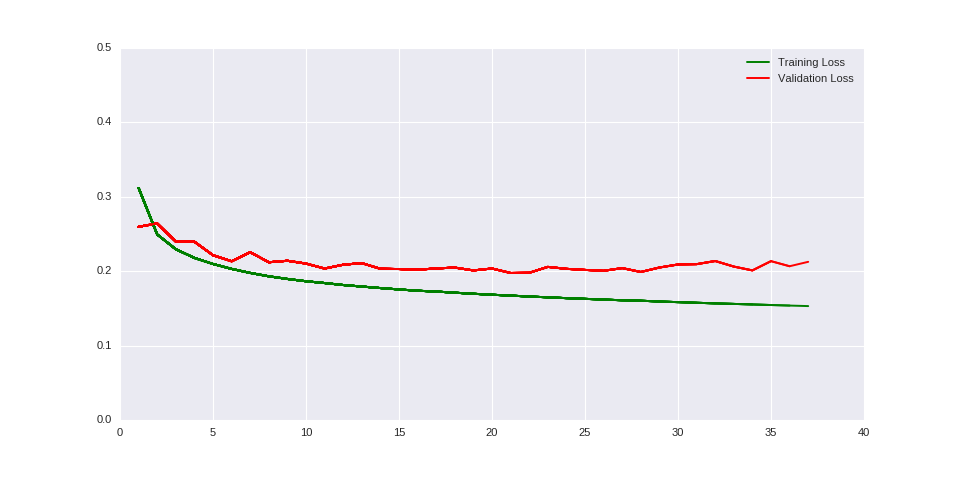

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3121

2017-04-01 03:45:32,814 : INFO : Found lower val loss for epoch 1 => 0.25967


254767/254767 [==============================] - 13s - loss: 0.3119 - val_loss: 0.2597
Epoch 2/200
254767/254767 [==============================] - 13s - loss: 0.2494 - val_loss: 0.2642
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2295

2017-04-01 03:45:59,756 : INFO : Found lower val loss for epoch 3 => 0.23977


254767/254767 [==============================] - 13s - loss: 0.2295 - val_loss: 0.2398
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2179

2017-04-01 03:46:14,258 : INFO : Found lower val loss for epoch 4 => 0.23962


254767/254767 [==============================] - 14s - loss: 0.2179 - val_loss: 0.2396
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2097

2017-04-01 03:46:31,279 : INFO : Found lower val loss for epoch 5 => 0.22149


254767/254767 [==============================] - 17s - loss: 0.2097 - val_loss: 0.2215
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2031

2017-04-01 03:46:48,172 : INFO : Found lower val loss for epoch 6 => 0.21337


254767/254767 [==============================] - 16s - loss: 0.2031 - val_loss: 0.2134
Epoch 7/200
254767/254767 [==============================] - 17s - loss: 0.1977 - val_loss: 0.2255
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1932

2017-04-01 03:47:21,621 : INFO : Found lower val loss for epoch 8 => 0.21204


254767/254767 [==============================] - 16s - loss: 0.1931 - val_loss: 0.2120
Epoch 9/200
254767/254767 [==============================] - 16s - loss: 0.1896 - val_loss: 0.2140
Epoch 10/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1865

2017-04-01 03:47:54,451 : INFO : Found lower val loss for epoch 10 => 0.21025


254767/254767 [==============================] - 16s - loss: 0.1865 - val_loss: 0.2102
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1841

2017-04-01 03:48:11,113 : INFO : Found lower val loss for epoch 11 => 0.20356


254767/254767 [==============================] - 16s - loss: 0.1841 - val_loss: 0.2036
Epoch 12/200
254767/254767 [==============================] - 16s - loss: 0.1814 - val_loss: 0.2087
Epoch 13/200
254767/254767 [==============================] - 16s - loss: 0.1794 - val_loss: 0.2109
Epoch 14/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1773

2017-04-01 03:49:00,678 : INFO : Found lower val loss for epoch 14 => 0.20323


254767/254767 [==============================] - 16s - loss: 0.1773 - val_loss: 0.2032
Epoch 15/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1755

2017-04-01 03:49:17,478 : INFO : Found lower val loss for epoch 15 => 0.20291
2017-04-01 03:49:17,479 : INFO : Validation Loss Reduced 10 times
2017-04-01 03:49:17,481 : INFO : Evaluating on Validation Data
2017-04-01 03:49:29,049 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.629 | Top 3: 0.948 | Top 5: 0.990 | F1 Micro: 0.702 | F1 Macro: 0.634
254767/254767 [==============================] - 29s - loss: 0.1755 - val_loss: 0.2029
Epoch 16/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1738

2017-04-01 03:49:44,944 : INFO : Found lower val loss for epoch 16 => 0.20198


254767/254767 [==============================] - 14s - loss: 0.1738 - val_loss: 0.2020
Epoch 17/200
254767/254767 [==============================] - 16s - loss: 0.1727 - val_loss: 0.2037
Epoch 18/200
254767/254767 [==============================] - 15s - loss: 0.1711 - val_loss: 0.2048
Epoch 19/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1697

2017-04-01 03:50:32,686 : INFO : Found lower val loss for epoch 19 => 0.20104


254767/254767 [==============================] - 15s - loss: 0.1697 - val_loss: 0.2010
Epoch 20/200
254767/254767 [==============================] - 16s - loss: 0.1684 - val_loss: 0.2036
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1672

2017-04-01 03:51:04,784 : INFO : Found lower val loss for epoch 21 => 0.19761


254767/254767 [==============================] - 15s - loss: 0.1672 - val_loss: 0.1976
Epoch 22/200
254767/254767 [==============================] - 15s - loss: 0.1660 - val_loss: 0.1979
Epoch 23/200
254767/254767 [==============================] - 15s - loss: 0.1649 - val_loss: 0.2058
Epoch 24/200
254767/254767 [==============================] - 16s - loss: 0.1638 - val_loss: 0.2032
Epoch 25/200
254767/254767 [==============================] - 15s - loss: 0.1628 - val_loss: 0.2017
Epoch 26/200
254767/254767 [==============================] - 14s - loss: 0.1619 - val_loss: 0.2005
Epoch 27/200
254767/254767 [==============================] - 15s - loss: 0.1609 - val_loss: 0.2042
Epoch 28/200
254767/254767 [==============================] - 15s - loss: 0.1603 - val_loss: 0.1990
Epoch 29/200
254767/254767 [==============================] - 15s - loss: 0.1592 - val_loss: 0.2049
Epoch 30/200
254767/254767 [==============================] - 15s - loss: 0.1584 - val_loss: 0.2091
Epoch 31/200


2017-04-01 03:55:14,296 : INFO : Evaluating on Training Data
2017-04-01 03:55:45,095 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.509 | Top 3: 0.969 | Top 5: 0.994 | F1 Micro: 0.816 | F1 Macro: 0.744


2017-04-01 03:55:51,691 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 03:55:59,087 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.622 | Top 3: 0.948 | Top 5: 0.990 | F1 Micro: 0.702 | F1 Macro: 0.637
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 500}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 03:56:00,982 : INFO : Loading Training Document Stats
2017-04-01 03:56:17,736 : INFO : Loading Training Data from file


Max Size: 4


2017-04-01 03:56:18,000 : INFO : Loading Validation Document Stats


(254767, 4, 200)
(254767, 8)


2017-04-01 03:56:21,932 : INFO : Loading Validation Data from file
2017-04-01 03:56:21,984 : INFO : Loading Validation Labels
2017-04-01 03:56:21,986 : INFO : ***************************************************************************************
2017-04-01 03:56:21,987 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_500


(60957, 4, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_4 (Convolution1D)  (None, 4, 500)        300500      convolution1d_input_4[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     convolution1d_4[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 2306508
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


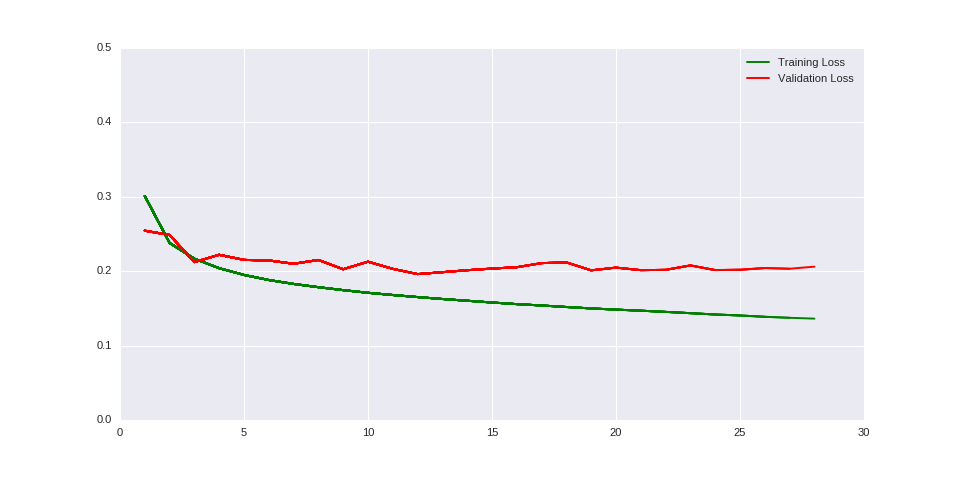

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3012

2017-04-01 03:56:51,038 : INFO : Found lower val loss for epoch 1 => 0.25443


254767/254767 [==============================] - 15s - loss: 0.3010 - val_loss: 0.2544
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2380

2017-04-01 03:57:07,553 : INFO : Found lower val loss for epoch 2 => 0.24873


254767/254767 [==============================] - 16s - loss: 0.2379 - val_loss: 0.2487
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2168

2017-04-01 03:57:26,362 : INFO : Found lower val loss for epoch 3 => 0.21222


254767/254767 [==============================] - 18s - loss: 0.2168 - val_loss: 0.2122
Epoch 4/200
254767/254767 [==============================] - 18s - loss: 0.2040 - val_loss: 0.2221
Epoch 5/200
254767/254767 [==============================] - 19s - loss: 0.1950 - val_loss: 0.2152
Epoch 6/200
254767/254767 [==============================] - 18s - loss: 0.1881 - val_loss: 0.2145
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1829

2017-04-01 03:58:43,001 : INFO : Found lower val loss for epoch 7 => 0.20998


254767/254767 [==============================] - 19s - loss: 0.1829 - val_loss: 0.2100
Epoch 8/200
254767/254767 [==============================] - 19s - loss: 0.1785 - val_loss: 0.2151
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1746

2017-04-01 03:59:21,286 : INFO : Found lower val loss for epoch 9 => 0.20263


254767/254767 [==============================] - 18s - loss: 0.1746 - val_loss: 0.2026
Epoch 10/200
254767/254767 [==============================] - 19s - loss: 0.1710 - val_loss: 0.2128
Epoch 11/200
254767/254767 [==============================] - 19s - loss: 0.1680 - val_loss: 0.2031
Epoch 12/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1653

2017-04-01 04:00:17,884 : INFO : Found lower val loss for epoch 12 => 0.19612


254767/254767 [==============================] - 18s - loss: 0.1652 - val_loss: 0.1961
Epoch 13/200
254767/254767 [==============================] - 19s - loss: 0.1626 - val_loss: 0.1987
Epoch 14/200
254767/254767 [==============================] - 18s - loss: 0.1603 - val_loss: 0.2013
Epoch 15/200
254767/254767 [==============================] - 18s - loss: 0.1579 - val_loss: 0.2035
Epoch 16/200
254767/254767 [==============================] - 19s - loss: 0.1557 - val_loss: 0.2054
Epoch 17/200
254767/254767 [==============================] - 19s - loss: 0.1539 - val_loss: 0.2109
Epoch 18/200
254767/254767 [==============================] - 19s - loss: 0.1519 - val_loss: 0.2118
Epoch 19/200
254767/254767 [==============================] - 18s - loss: 0.1500 - val_loss: 0.2012
Epoch 20/200
254767/254767 [==============================] - 19s - loss: 0.1484 - val_loss: 0.2048
Epoch 21/200
254767/254767 [==============================] - 18s - loss: 0.1469 - val_loss: 0.2014
Epoch 22/200


2017-04-01 04:05:36,500 : INFO : Evaluating on Training Data
2017-04-01 04:06:19,851 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.454 | Top 3: 0.976 | Top 5: 0.996 | F1 Micro: 0.844 | F1 Macro: 0.790


2017-04-01 04:06:27,342 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 04:06:38,010 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.604 | Top 3: 0.952 | Top 5: 0.992 | F1 Micro: 0.710 | F1 Macro: 0.650
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 32}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 04:06:40,130 : INFO : Loading Training Document Stats
2017-04-01 04:06:57,065 : INFO : Loading Training Data from file


Max Size: 34


2017-04-01 04:07:41,594 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-04-01 04:07:45,709 : INFO : Loading Validation Data from file
2017-04-01 04:07:56,448 : INFO : Loading Validation Labels
2017-04-01 04:07:56,452 : INFO : ***************************************************************************************
2017-04-01 04:07:56,453 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_32


(60957, 34, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_5 (Convolution1D)  (None, 34, 32)        19232       convolution1d_input_5[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           1066000     convolution1d_5[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 1089240
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


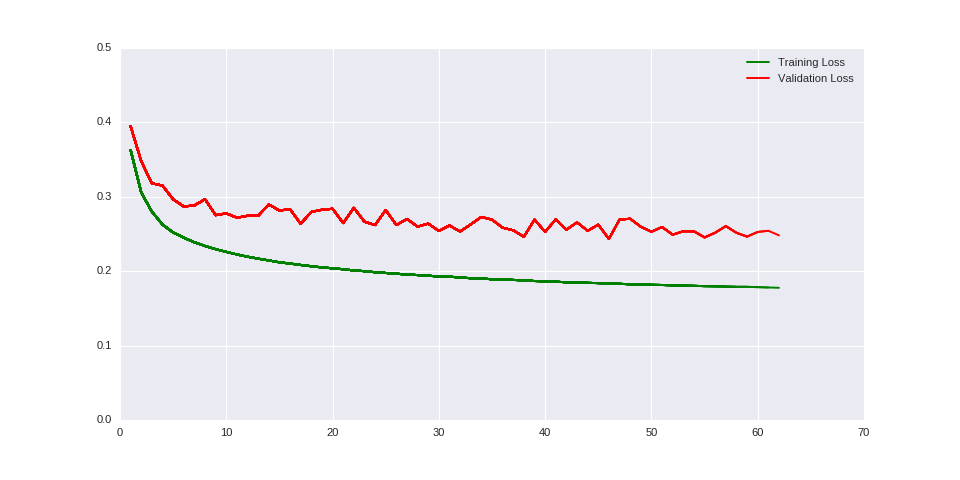

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3630

2017-04-01 04:09:10,632 : INFO : Found lower val loss for epoch 1 => 0.39476


254767/254767 [==============================] - 60s - loss: 0.3629 - val_loss: 0.3948
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3057

2017-04-01 04:10:15,829 : INFO : Found lower val loss for epoch 2 => 0.34773


254767/254767 [==============================] - 65s - loss: 0.3057 - val_loss: 0.3477
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2801

2017-04-01 04:11:20,314 : INFO : Found lower val loss for epoch 3 => 0.3181


254767/254767 [==============================] - 64s - loss: 0.2800 - val_loss: 0.3181
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2627

2017-04-01 04:12:26,208 : INFO : Found lower val loss for epoch 4 => 0.31504


254767/254767 [==============================] - 65s - loss: 0.2627 - val_loss: 0.3150
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2520

2017-04-01 04:13:31,166 : INFO : Found lower val loss for epoch 5 => 0.29665


254767/254767 [==============================] - 64s - loss: 0.2520 - val_loss: 0.2967
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2451

2017-04-01 04:14:36,726 : INFO : Found lower val loss for epoch 6 => 0.28696


254767/254767 [==============================] - 65s - loss: 0.2450 - val_loss: 0.2870
Epoch 7/200
254767/254767 [==============================] - 64s - loss: 0.2389 - val_loss: 0.2884
Epoch 8/200
254767/254767 [==============================] - 65s - loss: 0.2339 - val_loss: 0.2967
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2296

2017-04-01 04:17:51,820 : INFO : Found lower val loss for epoch 9 => 0.27535


254767/254767 [==============================] - 64s - loss: 0.2296 - val_loss: 0.2753
Epoch 10/200
254767/254767 [==============================] - 65s - loss: 0.2260 - val_loss: 0.2777
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2225

2017-04-01 04:20:02,499 : INFO : Found lower val loss for epoch 11 => 0.27192


254767/254767 [==============================] - 65s - loss: 0.2225 - val_loss: 0.2719
Epoch 12/200
254767/254767 [==============================] - 64s - loss: 0.2195 - val_loss: 0.2745
Epoch 13/200
254767/254767 [==============================] - 64s - loss: 0.2168 - val_loss: 0.2745
Epoch 14/200
254767/254767 [==============================] - 64s - loss: 0.2145 - val_loss: 0.2897
Epoch 15/200
254767/254767 [==============================] - 63s - loss: 0.2119 - val_loss: 0.2816
Epoch 16/200
254767/254767 [==============================] - 64s - loss: 0.2103 - val_loss: 0.2833
Epoch 17/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2084

2017-04-01 04:26:30,345 : INFO : Found lower val loss for epoch 17 => 0.26366


254767/254767 [==============================] - 65s - loss: 0.2084 - val_loss: 0.2637
Epoch 18/200
254767/254767 [==============================] - 64s - loss: 0.2067 - val_loss: 0.2797
Epoch 19/200
254767/254767 [==============================] - 64s - loss: 0.2051 - val_loss: 0.2826
Epoch 20/200
254767/254767 [==============================] - 64s - loss: 0.2039 - val_loss: 0.2839
Epoch 21/200
254767/254767 [==============================] - 65s - loss: 0.2026 - val_loss: 0.2647
Epoch 22/200
254767/254767 [==============================] - 65s - loss: 0.2010 - val_loss: 0.2852
Epoch 23/200
254767/254767 [==============================] - 69s - loss: 0.2001 - val_loss: 0.2666
Epoch 24/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1986

2017-04-01 04:34:20,492 : INFO : Found lower val loss for epoch 24 => 0.26198
2017-04-01 04:34:20,493 : INFO : Validation Loss Reduced 10 times
2017-04-01 04:34:20,494 : INFO : Evaluating on Validation Data
2017-04-01 04:34:57,950 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.913 | Top 3: 0.903 | Top 5: 0.980 | F1 Micro: 0.577 | F1 Macro: 0.446
254767/254767 [==============================] - 114s - loss: 0.1986 - val_loss: 0.2620
Epoch 25/200
254767/254767 [==============================] - 64s - loss: 0.1976 - val_loss: 0.2822
Epoch 26/200
254767/254767 [==============================] - 66s - loss: 0.1966 - val_loss: 0.2620
Epoch 27/200
254767/254767 [==============================] - 64s - loss: 0.1955 - val_loss: 0.2702
Epoch 28/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1948

2017-04-01 04:39:20,004 : INFO : Found lower val loss for epoch 28 => 0.25988


254767/254767 [==============================] - 64s - loss: 0.1948 - val_loss: 0.2599
Epoch 29/200
254767/254767 [==============================] - 65s - loss: 0.1939 - val_loss: 0.2640
Epoch 30/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1929

2017-04-01 04:41:30,673 : INFO : Found lower val loss for epoch 30 => 0.25403


254767/254767 [==============================] - 64s - loss: 0.1929 - val_loss: 0.2540
Epoch 31/200
254767/254767 [==============================] - 66s - loss: 0.1927 - val_loss: 0.2614
Epoch 32/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1915

2017-04-01 04:43:43,122 : INFO : Found lower val loss for epoch 32 => 0.2533


254767/254767 [==============================] - 66s - loss: 0.1915 - val_loss: 0.2533
Epoch 33/200
254767/254767 [==============================] - 66s - loss: 0.1906 - val_loss: 0.2629
Epoch 34/200
254767/254767 [==============================] - 65s - loss: 0.1902 - val_loss: 0.2729
Epoch 35/200
254767/254767 [==============================] - 64s - loss: 0.1891 - val_loss: 0.2693
Epoch 36/200
254767/254767 [==============================] - 65s - loss: 0.1889 - val_loss: 0.2584
Epoch 37/200
254767/254767 [==============================] - 65s - loss: 0.1883 - val_loss: 0.2549
Epoch 38/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1877

2017-04-01 04:50:15,468 : INFO : Found lower val loss for epoch 38 => 0.24624


254767/254767 [==============================] - 64s - loss: 0.1877 - val_loss: 0.2462
Epoch 39/200
254767/254767 [==============================] - 64s - loss: 0.1868 - val_loss: 0.2694
Epoch 40/200
254767/254767 [==============================] - 65s - loss: 0.1865 - val_loss: 0.2528
Epoch 41/200
254767/254767 [==============================] - 64s - loss: 0.1859 - val_loss: 0.2698
Epoch 42/200
254767/254767 [==============================] - 65s - loss: 0.1851 - val_loss: 0.2557
Epoch 43/200
254767/254767 [==============================] - 64s - loss: 0.1849 - val_loss: 0.2656
Epoch 44/200
254767/254767 [==============================] - 65s - loss: 0.1843 - val_loss: 0.2543
Epoch 45/200
254767/254767 [==============================] - 65s - loss: 0.1840 - val_loss: 0.2626
Epoch 46/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1834

2017-04-01 04:58:55,711 : INFO : Found lower val loss for epoch 46 => 0.24337


254767/254767 [==============================] - 64s - loss: 0.1834 - val_loss: 0.2434
Epoch 47/200
254767/254767 [==============================] - 65s - loss: 0.1830 - val_loss: 0.2694
Epoch 48/200
254767/254767 [==============================] - 67s - loss: 0.1825 - val_loss: 0.2705
Epoch 49/200
254767/254767 [==============================] - 73s - loss: 0.1822 - val_loss: 0.2598
Epoch 50/200
254767/254767 [==============================] - 67s - loss: 0.1817 - val_loss: 0.2530
Epoch 51/200
254767/254767 [==============================] - 68s - loss: 0.1815 - val_loss: 0.2594
Epoch 52/200
254767/254767 [==============================] - 67s - loss: 0.1810 - val_loss: 0.2491
Epoch 53/200
254767/254767 [==============================] - 66s - loss: 0.1807 - val_loss: 0.2538
Epoch 54/200
254767/254767 [==============================] - 68s - loss: 0.1803 - val_loss: 0.2536
Epoch 55/200
254767/254767 [==============================] - 68s - loss: 0.1799 - val_loss: 0.2454
Epoch 56/200


2017-04-01 05:17:04,052 : INFO : Evaluating on Training Data
2017-04-01 05:19:33,348 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.592 | Top 3: 0.958 | Top 5: 0.991 | F1 Micro: 0.778 | F1 Macro: 0.681


2017-04-01 05:19:39,772 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 05:20:15,468 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.802 | Top 3: 0.923 | Top 5: 0.985 | F1 Micro: 0.624 | F1 Macro: 0.536
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 200}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 05:20:17,334 : INFO : Loading Training Document Stats
2017-04-01 05:20:43,659 : INFO : Loading Training Data from file


Max Size: 34


2017-04-01 05:23:21,810 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-04-01 05:23:29,965 : INFO : Loading Validation Data from file
2017-04-01 05:23:40,828 : INFO : Loading Validation Labels
2017-04-01 05:23:40,846 : INFO : ***************************************************************************************
2017-04-01 05:23:40,848 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_200


(60957, 34, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_6 (Convolution1D)  (None, 34, 200)       120200      convolution1d_input_6[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           1402000     convolution1d_6[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 1526208
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


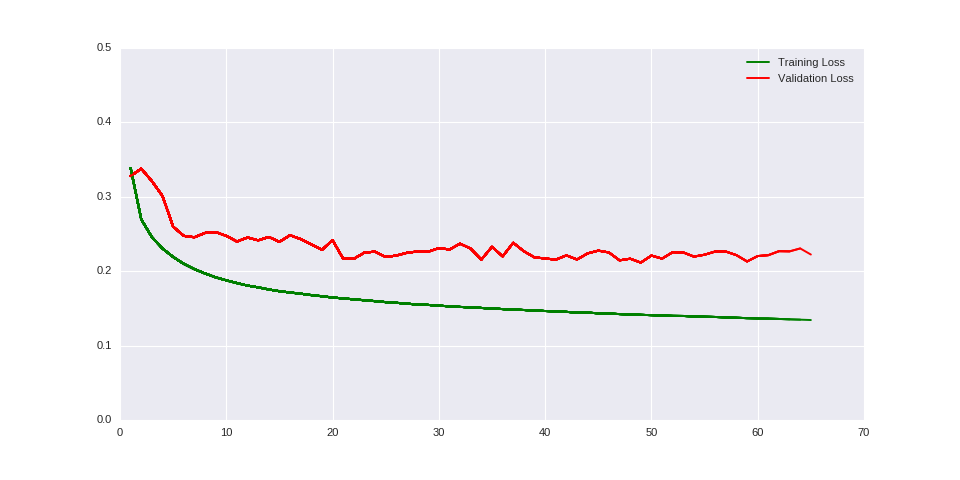

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3389

2017-04-01 05:25:04,275 : INFO : Found lower val loss for epoch 1 => 0.32787


254767/254767 [==============================] - 70s - loss: 0.3388 - val_loss: 0.3279
Epoch 2/200
254767/254767 [==============================] - 76s - loss: 0.2697 - val_loss: 0.3378
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2458

2017-04-01 05:27:37,242 : INFO : Found lower val loss for epoch 3 => 0.32107


254767/254767 [==============================] - 76s - loss: 0.2458 - val_loss: 0.3211
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2305

2017-04-01 05:28:53,434 : INFO : Found lower val loss for epoch 4 => 0.30108


254767/254767 [==============================] - 76s - loss: 0.2305 - val_loss: 0.3011
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2192

2017-04-01 05:30:09,135 : INFO : Found lower val loss for epoch 5 => 0.25987


254767/254767 [==============================] - 75s - loss: 0.2191 - val_loss: 0.2599
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2099

2017-04-01 05:31:26,323 : INFO : Found lower val loss for epoch 6 => 0.2475


254767/254767 [==============================] - 77s - loss: 0.2099 - val_loss: 0.2475
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2027

2017-04-01 05:32:42,867 : INFO : Found lower val loss for epoch 7 => 0.24563


254767/254767 [==============================] - 76s - loss: 0.2027 - val_loss: 0.2456
Epoch 8/200
254767/254767 [==============================] - 76s - loss: 0.1969 - val_loss: 0.2514
Epoch 9/200
254767/254767 [==============================] - 77s - loss: 0.1918 - val_loss: 0.2526
Epoch 10/200
254767/254767 [==============================] - 77s - loss: 0.1877 - val_loss: 0.2475
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1840

2017-04-01 05:37:51,705 : INFO : Found lower val loss for epoch 11 => 0.23989


254767/254767 [==============================] - 77s - loss: 0.1840 - val_loss: 0.2399
Epoch 12/200
254767/254767 [==============================] - 77s - loss: 0.1806 - val_loss: 0.2453
Epoch 13/200
254767/254767 [==============================] - 77s - loss: 0.1783 - val_loss: 0.2415
Epoch 14/200
254767/254767 [==============================] - 76s - loss: 0.1754 - val_loss: 0.2460
Epoch 15/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1731

2017-04-01 05:42:59,539 : INFO : Found lower val loss for epoch 15 => 0.23946


254767/254767 [==============================] - 76s - loss: 0.1731 - val_loss: 0.2395
Epoch 16/200
254767/254767 [==============================] - 77s - loss: 0.1714 - val_loss: 0.2483
Epoch 17/200
254767/254767 [==============================] - 77s - loss: 0.1698 - val_loss: 0.2431
Epoch 18/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1678

2017-04-01 05:46:52,024 : INFO : Found lower val loss for epoch 18 => 0.2362


254767/254767 [==============================] - 77s - loss: 0.1679 - val_loss: 0.2362
Epoch 19/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1663

2017-04-01 05:48:09,242 : INFO : Found lower val loss for epoch 19 => 0.22864
2017-04-01 05:48:09,244 : INFO : Validation Loss Reduced 10 times
2017-04-01 05:48:09,245 : INFO : Evaluating on Validation Data
2017-04-01 05:48:47,474 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.715 | Top 3: 0.942 | Top 5: 0.990 | F1 Micro: 0.652 | F1 Macro: 0.584
254767/254767 [==============================] - 117s - loss: 0.1663 - val_loss: 0.2286
Epoch 20/200
254767/254767 [==============================] - 76s - loss: 0.1646 - val_loss: 0.2417
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1635

2017-04-01 05:51:23,052 : INFO : Found lower val loss for epoch 21 => 0.2167


254767/254767 [==============================] - 77s - loss: 0.1634 - val_loss: 0.2167
Epoch 22/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1622

2017-04-01 05:52:40,196 : INFO : Found lower val loss for epoch 22 => 0.21669


254767/254767 [==============================] - 77s - loss: 0.1621 - val_loss: 0.2167
Epoch 23/200
254767/254767 [==============================] - 76s - loss: 0.1609 - val_loss: 0.2250
Epoch 24/200
254767/254767 [==============================] - 77s - loss: 0.1598 - val_loss: 0.2263
Epoch 25/200
254767/254767 [==============================] - 76s - loss: 0.1584 - val_loss: 0.2191
Epoch 26/200
254767/254767 [==============================] - 77s - loss: 0.1575 - val_loss: 0.2210
Epoch 27/200
254767/254767 [==============================] - 76s - loss: 0.1564 - val_loss: 0.2247
Epoch 28/200
254767/254767 [==============================] - 76s - loss: 0.1552 - val_loss: 0.2265
Epoch 29/200
254767/254767 [==============================] - 76s - loss: 0.1547 - val_loss: 0.2262
Epoch 30/200
254767/254767 [==============================] - 77s - loss: 0.1536 - val_loss: 0.2311
Epoch 31/200
254767/254767 [==============================] - 76s - loss: 0.1528 - val_loss: 0.2292
Epoch 32/200


2017-04-01 06:08:01,661 : INFO : Found lower val loss for epoch 34 => 0.21562


254767/254767 [==============================] - 76s - loss: 0.1506 - val_loss: 0.2156
Epoch 35/200
254767/254767 [==============================] - 77s - loss: 0.1499 - val_loss: 0.2328
Epoch 36/200
254767/254767 [==============================] - 76s - loss: 0.1491 - val_loss: 0.2199
Epoch 37/200
254767/254767 [==============================] - 77s - loss: 0.1484 - val_loss: 0.2382
Epoch 38/200
254767/254767 [==============================] - 76s - loss: 0.1478 - val_loss: 0.2268
Epoch 39/200
254767/254767 [==============================] - 76s - loss: 0.1472 - val_loss: 0.2186
Epoch 40/200
254767/254767 [==============================] - 76s - loss: 0.1465 - val_loss: 0.2171
Epoch 41/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1461

2017-04-01 06:16:59,510 : INFO : Found lower val loss for epoch 41 => 0.21549


254767/254767 [==============================] - 77s - loss: 0.1461 - val_loss: 0.2155
Epoch 42/200
254767/254767 [==============================] - 76s - loss: 0.1453 - val_loss: 0.2212
Epoch 43/200
254767/254767 [==============================] - 76s - loss: 0.1444 - val_loss: 0.2157
Epoch 44/200
254767/254767 [==============================] - 76s - loss: 0.1443 - val_loss: 0.2239
Epoch 45/200
254767/254767 [==============================] - 77s - loss: 0.1434 - val_loss: 0.2277
Epoch 46/200
254767/254767 [==============================] - 77s - loss: 0.1430 - val_loss: 0.2252
Epoch 47/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1423

2017-04-01 06:24:40,572 : INFO : Found lower val loss for epoch 47 => 0.2146


254767/254767 [==============================] - 76s - loss: 0.1424 - val_loss: 0.2146
Epoch 48/200
254767/254767 [==============================] - 76s - loss: 0.1419 - val_loss: 0.2168
Epoch 49/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1413

2017-04-01 06:27:13,630 : INFO : Found lower val loss for epoch 49 => 0.21155


254767/254767 [==============================] - 76s - loss: 0.1413 - val_loss: 0.2116
Epoch 50/200
254767/254767 [==============================] - 77s - loss: 0.1409 - val_loss: 0.2210
Epoch 51/200
254767/254767 [==============================] - 77s - loss: 0.1404 - val_loss: 0.2169
Epoch 52/200
254767/254767 [==============================] - 76s - loss: 0.1399 - val_loss: 0.2256
Epoch 53/200
254767/254767 [==============================] - 77s - loss: 0.1398 - val_loss: 0.2252
Epoch 54/200
254767/254767 [==============================] - 77s - loss: 0.1391 - val_loss: 0.2196
Epoch 55/200
254767/254767 [==============================] - 77s - loss: 0.1388 - val_loss: 0.2222
Epoch 56/200
254767/254767 [==============================] - 76s - loss: 0.1385 - val_loss: 0.2264
Epoch 57/200
254767/254767 [==============================] - 76s - loss: 0.1378 - val_loss: 0.2264
Epoch 58/200
254767/254767 [==============================] - 77s - loss: 0.1375 - val_loss: 0.2216
Epoch 59/200


2017-04-01 06:47:45,107 : INFO : Evaluating on Training Data
2017-04-01 06:50:17,275 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.445 | Top 3: 0.978 | Top 5: 0.997 | F1 Micro: 0.847 | F1 Macro: 0.795


2017-04-01 06:50:23,743 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 06:50:59,739 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.657 | Top 3: 0.948 | Top 5: 0.992 | F1 Micro: 0.680 | F1 Macro: 0.617
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': 500}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-01 06:51:01,634 : INFO : Loading Training Document Stats
2017-04-01 06:51:21,532 : INFO : Loading Training Data from file


Max Size: 34


2017-04-01 06:53:57,882 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-04-01 06:54:01,899 : INFO : Loading Validation Data from file
2017-04-01 06:54:13,738 : INFO : Loading Validation Labels
2017-04-01 06:54:13,748 : INFO : ***************************************************************************************
2017-04-01 06:54:13,750 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_1_conv_500


(60957, 34, 200)
(60957, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_7 (Convolution1D)  (None, 34, 500)       300500      convolution1d_input_7[0][0]      
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     convolution1d_7[0][0]            
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 2306508
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


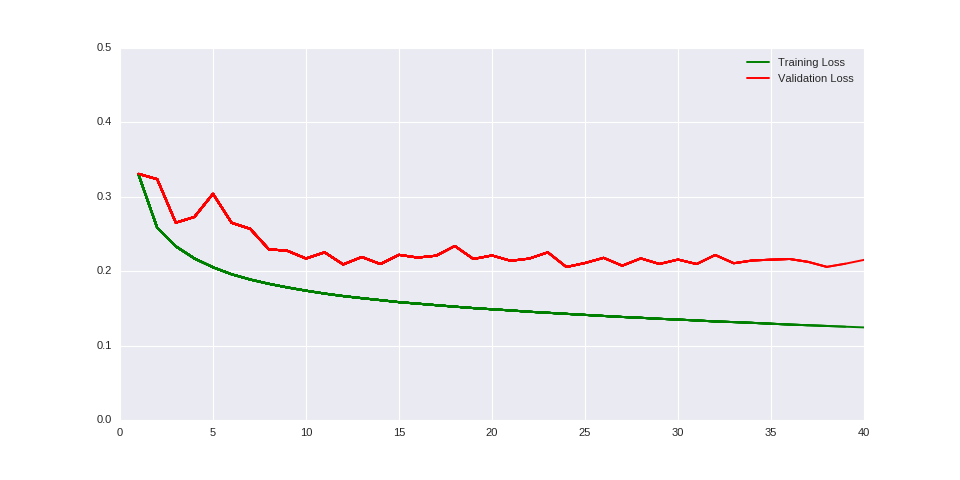

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3298

2017-04-01 06:55:47,858 : INFO : Found lower val loss for epoch 1 => 0.3308


254767/254767 [==============================] - 82s - loss: 0.3296 - val_loss: 0.3308
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2584

2017-04-01 06:57:11,444 : INFO : Found lower val loss for epoch 2 => 0.32366


254767/254767 [==============================] - 83s - loss: 0.2584 - val_loss: 0.3237
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2334

2017-04-01 06:58:34,746 : INFO : Found lower val loss for epoch 3 => 0.26518


254767/254767 [==============================] - 83s - loss: 0.2334 - val_loss: 0.2652
Epoch 4/200
254767/254767 [==============================] - 83s - loss: 0.2171 - val_loss: 0.2729
Epoch 5/200
254767/254767 [==============================] - 84s - loss: 0.2052 - val_loss: 0.3040
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1959

2017-04-01 07:02:46,750 : INFO : Found lower val loss for epoch 6 => 0.26506


254767/254767 [==============================] - 84s - loss: 0.1959 - val_loss: 0.2651
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1888

2017-04-01 07:04:11,189 : INFO : Found lower val loss for epoch 7 => 0.25694


254767/254767 [==============================] - 84s - loss: 0.1888 - val_loss: 0.2569
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1831

2017-04-01 07:05:35,448 : INFO : Found lower val loss for epoch 8 => 0.22952


254767/254767 [==============================] - 84s - loss: 0.1830 - val_loss: 0.2295
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1782

2017-04-01 07:06:59,366 : INFO : Found lower val loss for epoch 9 => 0.2274


254767/254767 [==============================] - 83s - loss: 0.1782 - val_loss: 0.2274
Epoch 10/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1738

2017-04-01 07:08:22,683 : INFO : Found lower val loss for epoch 10 => 0.21705


254767/254767 [==============================] - 83s - loss: 0.1738 - val_loss: 0.2171
Epoch 11/200
254767/254767 [==============================] - 83s - loss: 0.1699 - val_loss: 0.2254
Epoch 12/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1666

2017-04-01 07:11:09,826 : INFO : Found lower val loss for epoch 12 => 0.2091


254767/254767 [==============================] - 83s - loss: 0.1666 - val_loss: 0.2091
Epoch 13/200
254767/254767 [==============================] - 83s - loss: 0.1637 - val_loss: 0.2191
Epoch 14/200
254767/254767 [==============================] - 84s - loss: 0.1611 - val_loss: 0.2096
Epoch 15/200
254767/254767 [==============================] - 84s - loss: 0.1584 - val_loss: 0.2220
Epoch 16/200
254767/254767 [==============================] - 84s - loss: 0.1564 - val_loss: 0.2183
Epoch 17/200
254767/254767 [==============================] - 83s - loss: 0.1543 - val_loss: 0.2209
Epoch 18/200
254767/254767 [==============================] - 83s - loss: 0.1523 - val_loss: 0.2339
Epoch 19/200
254767/254767 [==============================] - 83s - loss: 0.1504 - val_loss: 0.2164
Epoch 20/200
254767/254767 [==============================] - 83s - loss: 0.1488 - val_loss: 0.2212
Epoch 21/200
254767/254767 [==============================] - 83s - loss: 0.1473 - val_loss: 0.2140
Epoch 22/200


2017-04-01 07:27:56,724 : INFO : Found lower val loss for epoch 24 => 0.20564
2017-04-01 07:27:56,725 : INFO : Validation Loss Reduced 10 times
2017-04-01 07:27:56,726 : INFO : Evaluating on Validation Data
2017-04-01 07:28:38,761 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.618 | Top 3: 0.951 | Top 5: 0.992 | F1 Micro: 0.703 | F1 Macro: 0.645
254767/254767 [==============================] - 127s - loss: 0.1427 - val_loss: 0.2056
Epoch 25/200
254767/254767 [==============================] - 83s - loss: 0.1413 - val_loss: 0.2110
Epoch 26/200
254767/254767 [==============================] - 83s - loss: 0.1399 - val_loss: 0.2180
Epoch 27/200
254767/254767 [==============================] - 83s - loss: 0.1385 - val_loss: 0.2074
Epoch 28/200
254767/254767 [==============================] - 84s - loss: 0.1374 - val_loss: 0.2172
Epoch 29/200
254767/254767 [==============================] - 84s - loss: 0.1360 - val_loss: 0.2097
Epoch 30/200
254767/254767 [==============================] - 84s - loss: 0.1350 - val_loss: 0.2156
Epoch 31/200
254767/254767 [==============================] - 83s - loss: 0.1338 - val_loss: 0.2096
Epoch 32/200
254767/254767 [==============================] - 84s - loss: 0.1325 - val_loss: 0.2218
Epoc

2017-04-01 07:51:00,739 : INFO : Evaluating on Training Data
2017-04-01 07:53:47,505 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.419 | Top 3: 0.980 | Top 5: 0.997 | F1 Micro: 0.863 | F1 Macro: 0.814


2017-04-01 07:53:54,013 : INFO : Evaluating on Validation Data using saved best weights
2017-04-01 07:54:33,532 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.618 | Top 3: 0.951 | Top 5: 0.992 | F1 Micro: 0.703 | F1 Macro: 0.645


In [34]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    doc2vec_model = None

    training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
    validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

    print GLOBAL_VARS.MODEL_NAME
    
#     print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
#     if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
#         doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
#         doc2vec_model.workers = NUM_CORES
#         GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
#     else:
#         info("Couldnt find the doc2vec model with epoch {}".format(epoch))
#         raise Exception()
    
    time.sleep(0.2)
    
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))
    
    MAX_SIZE = 1 # for document vector
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PARTS

    if PARTS_LEVEL >= LEVEL_CHUNKS:
        MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PART_CHUNKS

    print "Max Size: {}".format(MAX_SIZE)
    
    X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)
    print X.shape
    print y.shape
    
    validation_dict = None
#     validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))
    Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)
    print Xv.shape
    print yv.shape
    
    
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))


    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
    time.sleep(0.2)
    info('Evaluating on Training Data')
    yp = model.predict(X) # get raw probability for predicted labels
    yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))
        